# Estimating COVID-19's $R_t$ with Rainier (ported from PYMC)

Grzegorz Kossakowski & Maciek Zdanowicz - May 5 (beta)

Model originally built by [Kevin Systrom](https://twitter.com/kevin) in `Realtime Rt mcmc.ipynb` notebook, ported to [Rainier](https://rainier.fit) with lots of help from [Avi Bryant](https://twitter.com/avibryant). Model comparison for European countries is in `Realtime Rt plots only.ipynb`.

This notebook requires [Almond](https://almond.sh) to run.

It's a work in progress.

In [26]:
import $ivy.`com.stripe::rainier-core:0.3.3`
import $ivy.`com.stripe::rainier-notebook:0.3.3`

import $ivy.$                               

import $ivy.$                                   

In [27]:
import com.stripe.rainier.compute._
import com.stripe.rainier.core._
import com.stripe.rainier.sampler._
import com.stripe.rainier.notebook._

import com.stripe.rainier.compute._

import com.stripe.rainier.core._

import com.stripe.rainier.sampler._

import com.stripe.rainier.notebook._

In [28]:
PPrint.register(repl)

In [29]:
import $ivy.`com.github.tototoshi::scala-csv:1.3.6`
import com.github.tototoshi.csv._
import java.io.File
import scala.util.Try

import $ivy.$                                      

import com.github.tototoshi.csv._

import java.io.File

import scala.util.Try

In [30]:
def time[R](block: => R): R = {
    val t0 = System.nanoTime()
    val result = block    // call-by-name
    val t1 = System.nanoTime()
    val timeMilis = ((t1 - t0) / 1e6).toInt
    println(s"Elapsed time: $timeMilis ms")
    result
}

defined function time

In [31]:
val countriesOnsetData = {
    val csvReader = CSVReader.open(new File("data/onset.csv"))
    val xs = csvReader.allWithHeaders()
    csvReader.close()
    xs
}

countriesOnsetData: List[Map[String, String]] = List(
  Map(
    "country" -> "Austria",
    "date" -> "2020-02-06",
    "Onset" -> "1.180164888457808"
  ),
  Map(
    "country" -> "Austria",
    "date" -> "2020-02-07",
    "Onset" -> "1.236663433559651"
  ),
  Map(
    "country" -> "Austria",
    "date" -> "2020-02-08",
    "Onset" -> "1.6939864209505335"
  ),
  Map(
    "country" -> "Austria",
    "date" -> "2020-02-09",
    "Onset" -> "1.9956353055286131"
  ),
  Map(
    "country" -> "Austria",
    "date" -> "2020-02-10",
    "Onset" -> "2.630455868089234"
  ),
  Map(
    "country" -> "Austria",
    "date" -> "2020-02-11",
    "Onset" -> "2.842386032977692"
  ),
  Map(
    "country" -> "Austria",
    "date" -> "2020-02-12",
    "Onset" -> "3.0227934044616878"
  ),
  Map(
    "country" -> "Austria",
    "date" -> "2020-02-13",
...

In [32]:
import java.time.LocalDate
import java.time.chrono.ChronoLocalDate
// so comparisons work like max()
import scala.math.Ordering.Implicits._

def toDate(s: String): LocalDate =
    LocalDate.parse(s)

// we need to specify type parameter ChronoLocalDate (a super type of LocalDate) because
// that's what the comparison is defined for
countriesOnsetData.map(entry => toDate(entry("date"))).max[ChronoLocalDate]

import java.time.LocalDate

import java.time.chrono.ChronoLocalDate
// so comparisons work like max()

import scala.math.Ordering.Implicits._


defined function toDate
res31_4: LocalDate = 2020-06-03

In [33]:
val pdelayData = {
    val csvReader = CSVReader.open(new File("data/pdelay.csv"))
    val xs = csvReader.allWithHeaders()
    csvReader.close()
    xs
}

pdelayData: List[Map[String, String]] = List(
  Map("index" -> "0", "pdelay" -> "0.006547041707080504"),
  Map("index" -> "1", "pdelay" -> "0.04194956353055286"),
  Map("index" -> "2", "pdelay" -> "0.05771096023278371"),
  Map("index" -> "3", "pdelay" -> "0.06983511154219205"),
  Map("index" -> "4", "pdelay" -> "0.07153249272550921"),
  Map("index" -> "5", "pdelay" -> "0.08583899127061105"),
  Map("index" -> "6", "pdelay" -> "0.07953443258971872"),
  Map("index" -> "7", "pdelay" -> "0.07516973811833172"),
  Map("index" -> "8", "pdelay" -> "0.07710960232783705"),
  Map("index" -> "9", "pdelay" -> "0.07904946653734239"),
  Map("index" -> "10", "pdelay" -> "0.06304558680892337"),
  Map("index" -> "11", "pdelay" -> "0.0511639185257032"),
  Map("index" -> "12", "pdelay" -> "0.04485935984481086"),
  Map("index" -> "13", "pdelay" -> "0.038554801163918524"),
  Map("index" -> "14", "pdelay" -> "0.028855480116391854"),
  Map("index" -> "15", "pdelay" -> "0.026430649854510185"),
  Map("index" -> 

In [34]:
val pdelay = pdelayData.collect { case m => m("pdelay").toDouble }

pdelay: List[Double] = List(
  0.006547041707080504,
  0.04194956353055286,
  0.05771096023278371,
  0.06983511154219205,
  0.07153249272550921,
  0.08583899127061105,
  0.07953443258971872,
  0.07516973811833172,
  0.07710960232783705,
  0.07904946653734239,
  0.06304558680892337,
  0.0511639185257032,
  0.04485935984481086,
  0.038554801163918524,
  0.028855480116391854,
  0.026430649854510185,
  0.01915615906886518,
  0.02061105722599418,
  0.011881668283220174,
  0.009456838021338506,
  0.009699321047526674,
  0.006547041707080504,
  0.004122211445198836,
  0.0036372453928225023,
  0.002909796314258002,
  0.0036372453928225023,
  0.0019398642095053346,
  4.8496605237633366E-4,
  4.8496605237633366E-4,
  0.0,
  9.699321047526673E-4,
  2.4248302618816683E-4,
  4.8496605237633366E-4,
  7.274490785645005E-4,
  0.001454898157129001,
  2.4248302618816683E-4,
  4.8496605237633366E-4,
  7.274490785645005E-4,
...

In [35]:
def prepareDataForModel(xs: List[Long], pd: List[Double]): List[(Long,Double)] = {
    val cpd = pd.scanLeft(0.0)(_+_).tail
    val cpdPadded = List.fill(xs.size - pd.size)(1.0) ++ cpd.reverse
    // ensure that case numbers are always at least 1 so we avoid numerical issues involving 0
    // adding 1 across all counts doesn't change inputs in any material way
    // see the comment of `predictRt` method for the rationale
    xs.zip(cpdPadded)
}

defined function prepareDataForModel

Preparation of the other model

In [37]:
val samplerConfig = new DefaultConfig {
    override def massMatrixTuner() = new IdentityMassMatrixTuner
    override def sampler() = new HMCSampler(100)
    override val iterations = 1000
    override val warmupIterations = 1000
}

samplerConfig: DefaultConfig{def massMatrixTuner(): com.stripe.rainier.sampler.IdentityMassMatrixTuner;def sampler(): com.stripe.rainier.sampler.HMCSampler} = ammonite.$sess.cmd36$Helper$$anon$1@1c6361fa

Define a function that we'll use to retry the call to Rainier's `predict` that fails occassionally. Fortunately, the failure can be easily detected and 1-2 retries solves the issue.

In [38]:
def argmin[N](seq: Seq[N])(implicit num: Numeric[N]): Int = seq.indexOf(seq.min)

defined function argmin

In [39]:
import scala.collection.mutable.ArrayBuffer

/* Retry returns a value and a list of logs produced during consecutive attempts */
def retry[T](maxAttempts: Int, isSuccessful: T => (Boolean, Double)) (f: => T): (T, List[Double]) = {
    var i = 0
    var flag = false
    val logListBuf = ArrayBuffer.empty[Double]
    val resListBuf = ArrayBuffer.empty[T]
    do {
        i = i + 1
        val res = f
        resListBuf += res
        val (resBool, log) = isSuccessful(res)
        logListBuf += log
        val errorMsg = if(resBool) s"Success in [$i] iteration." else s"WARN: Attempt[$i] failed. Retrying..."
        println(errorMsg)
        flag = resBool
    } while (i < maxAttempts && !flag)
    val logList = logListBuf.toList
    return (resListBuf(argmin(logList)), logList)
}

import scala.collection.mutable.ArrayBuffer

/* Retry returns a value and a list of logs produced during consecutive attempts */

defined function retry

Fixed the parameters for all distributions

In [40]:
case class RtModelEstimates(rts: Vec[Real], 
                            rtsEstimates: List[Seq[Double]], 
                            serialInterval: Real, 
                            serialIntervalEstimates: Seq[Double])

defined class RtModelEstimates

In [40]:
// def predictRtOnsetLogProcess(onsetNumbers: List[Long], pdelay: List[Double]): (Vec[Real], List[Seq[Double]]) = {
    
//     val data = prepareDataForModel(onsetNumbers, pdelay)
    
//     val (model, rts) =  {
//         val (onset, cum_pdelay) = data.unzip
//         val serialInterval = Gamma(46.0,10.0).latent
//         val logR0 = Normal(0, 1).latent
//         val sigma = Exponential(10).latent
//         val diffs = Laplace(0,sigma).latentVec(data.size)
//         val logRts = Vec.from(diffs.toList.scanLeft(logR0)(_ + _))
//         val inferredYesterday = data.take(data.size-1).map { case (o_t, cp_t) => 
//             o_t/cp_t 
//         }.zipWithIndex
//         val expectedToday = Vec.from(inferredYesterday.zip(cum_pdelay.drop(1))).map { case ((infYest, i), cpd) =>
//             val lambda = infYest*cpd*((logRts(i).exp - 1)/serialInterval).exp
//             Poisson(lambda)
//         }
//         (Model.observe(onset.drop(1), expectedToday), logRts.map(_.exp))
//     }
    
//     def detectFailedRun(trace: Trace): (Boolean, Double) = {
//         // from: https://twitter.com/avibryant/status/1253049509128499201
//         val stat = trace.diagnostics.map(_.rHat).max
//         (stat < 1.1, stat)
//     }
    
//     val (trace, log) = retry(maxAttempts = 10, isSuccessful = detectFailedRun) {
//         model.sample(samplerConfig, 4)
//     }
    
//     rts -> trace.predict(rts)
// }

In [41]:
// direct (and faithful) translation of Systrom's MCMC model from
// Realtime Rt mcmc.ipynb up to different handling of this line
// mu = pm.math.maximum(.1, expected_today)
// my is the lambda of Poisson distribution that must be > 0.
// Kevin's solution is to take max(0.1, expected_today) to ensure
// that lambda > 0. However, `expected_today` is dependent only on input data and is not
// part of the model so we can ensure it's > 0 by fixing up the input data of the model.
// this is done in `prepareDataForModel`
def predictRt(onsetNumbers: List[Long], pdelay: List[Double], failedRunDetection: Boolean = true): (RtModelEstimates, List[Double]) = {
    
    val data = prepareDataForModel(onsetNumbers, pdelay)
    
    val (model, rts, serialInterval) = {
        val (onset, cum_pdelay) = data.unzip
        val serialInterval = Gamma(6.0,1/1.5).latent
        val sigma = Normal(0,0.03).latent.abs
        val Theta0 = Normal(0.1,0.1).latent
        val diffs = Laplace(0,sigma).latentVec(data.size) // Maybe normal would be better
        val ThetaT = Vec.from(diffs.toList.scanLeft(Theta0)(_ + _))
        val Rts = ThetaT.map(_*serialInterval + 1)
        val inferredYesterday = data.take(data.size-1).map { case (o_t, cp_t) => 
            o_t/cp_t 
        }.zipWithIndex
        val expectedToday = Vec.from(inferredYesterday.zip(cum_pdelay.drop(1))).map { case ((infYest, i), cpd) =>
            val lambda = Real(0.1).max(infYest * cpd * (ThetaT(i).exp))
            Poisson(lambda)
        }
        
        val obsModel = Model.observe(onset.drop(1), expectedToday)
        val trackSerialInterval = Model.track(Set(serialInterval))
        (obsModel.merge(trackSerialInterval), Rts, serialInterval)
    }
    
    def detectFailedRun(trace: Trace): (Boolean, Double) = {
        // from: https://twitter.com/avibryant/status/1253049509128499201
        val stat = trace.diagnostics.map(_.rHat).max
        val cond = !failedRunDetection || stat < 1.1
        (cond, stat)
    }
    
    val (trace, log) = retry(maxAttempts = 5, isSuccessful = detectFailedRun) {
        model.sample(samplerConfig, 2)
    }

    val rtme = RtModelEstimates(rts = rts, 
                 rtsEstimates = trace.predict(rts),
                 serialInterval = serialInterval,
                 serialIntervalEstimates = trace.predict(serialInterval))
    (rtme, log)
}

defined function predictRt

In [42]:
def median[N](seq: Seq[N])(implicit num: Numeric[N]): Double = {
    val l = (seq.map { n =>
      num.toDouble(n)
    }).sorted
    val n = l.size
    if(n % 2 == 1)
        l(n/2)
    else
        (l(n/2) + l(n/2-1))/2
}

defined function median

In [43]:
case class RtsDistributionStats(means: Seq[(Int, Double)], 
                                medians: Seq[(Int, Double)],
                                hdpis_90: Seq[(Int, (Double, Double))], 
                                hdpis_50: Seq[(Int, (Double, Double))])
def distributionStats(rts: Vec[Real], rtForecasts: List[Seq[Double]]): RtsDistributionStats = {
    val means = 0.until(rts.size).map{i => (i,mean(rtForecasts.map(_(i))))}
    val medians = 0.until(rts.size).map{i => (i,median(rtForecasts.map(_(i))))}
    val hdpis_90 = 0.until(rts.size).map{i => (i,hdpi(rtForecasts.map(_(i)),0.9))}
    val hdpis_50 = 0.until(rts.size).map{i => (i,hdpi(rtForecasts.map(_(i)),0.5))}
    RtsDistributionStats(means, medians, hdpis_90, hdpis_50)
}

defined class RtsDistributionStats
defined function distributionStats

In [44]:
val countryLogs = scala.collection.mutable.Map[String, List[Double]]()

def processLogs(country: String, logs: List[Double]) = {
    countryLogs(country) = logs
}

countryLogs: collection.mutable.Map[String, List[Double]] = Map()
defined function processLogs

Chain 1 Complete : Iteration: 1000 (31ms) Acceptance rate: 0.87 E-BFMI: 0.91 Step size: 0.003 Total gradient evaluations: 2e+05 (155us) Total time: 0: 1: 4

Chain 2 Complete : Iteration: 1000 (31ms) Acceptance rate: 0.82 E-BFMI: 0.69 Step size: 0.003 Total gradient evaluations: 2e+05 (156us) Total time: 0: 1: 3

WARN: Attempt[1] failed. Retrying...


Chain 1 Complete : Iteration: 1000 (31ms) Acceptance rate: 0.90 E-BFMI: 0.71 Step size: 0.003 Total gradient evaluations: 2e+05 (156us) Total time: 0: 1: 3

Chain 2 Complete : Iteration: 1000 (31ms) Acceptance rate: 0.76 E-BFMI: 0.91 Step size: 0.003 Total gradient evaluations: 2e+05 (155us) Total time: 0: 1: 3

WARN: Attempt[2] failed. Retrying...


Chain 1 Complete : Iteration: 1000 (31ms) Acceptance rate: 0.75 E-BFMI: 0.86 Step size: 0.004 Total gradient evaluations: 2e+05 (155us) Total time: 0: 1: 3

Chain 2 Complete : Iteration: 1000 (31ms) Acceptance rate: 0.91 E-BFMI: 0.89 Step size: 0.003 Total gradient evaluations: 2e+05 (156us) Total time: 0: 1: 3

WARN: Attempt[3] failed. Retrying...


Chain 1 Complete : Iteration: 1000 (31ms) Acceptance rate: 0.85 E-BFMI: 1.73 Step size: 0.0002 Total gradient evaluations: 2e+05 (156us) Total time: 0: 1: 3

Chain 2 Complete : Iteration: 1000 (31ms) Acceptance rate: 0.79 E-BFMI: 0.77 Step size: 0.004 Total gradient evaluations: 2e+05 (155us) Total time: 0: 1: 3

WARN: Attempt[4] failed. Retrying...


Chain 1 Complete : Iteration: 1000 (31ms) Acceptance rate: 0.87 E-BFMI: 0.72 Step size: 0.003 Total gradient evaluations: 2e+05 (155us) Total time: 0: 1: 3

Chain 2 Complete : Iteration: 1000 (31ms) Acceptance rate: 0.96 E-BFMI: 0.60 Step size: 0.003 Total gradient evaluations: 2e+05 (156us) Total time: 0: 1: 3

WARN: Attempt[5] failed. Retrying...
Elapsed time: 641248 ms


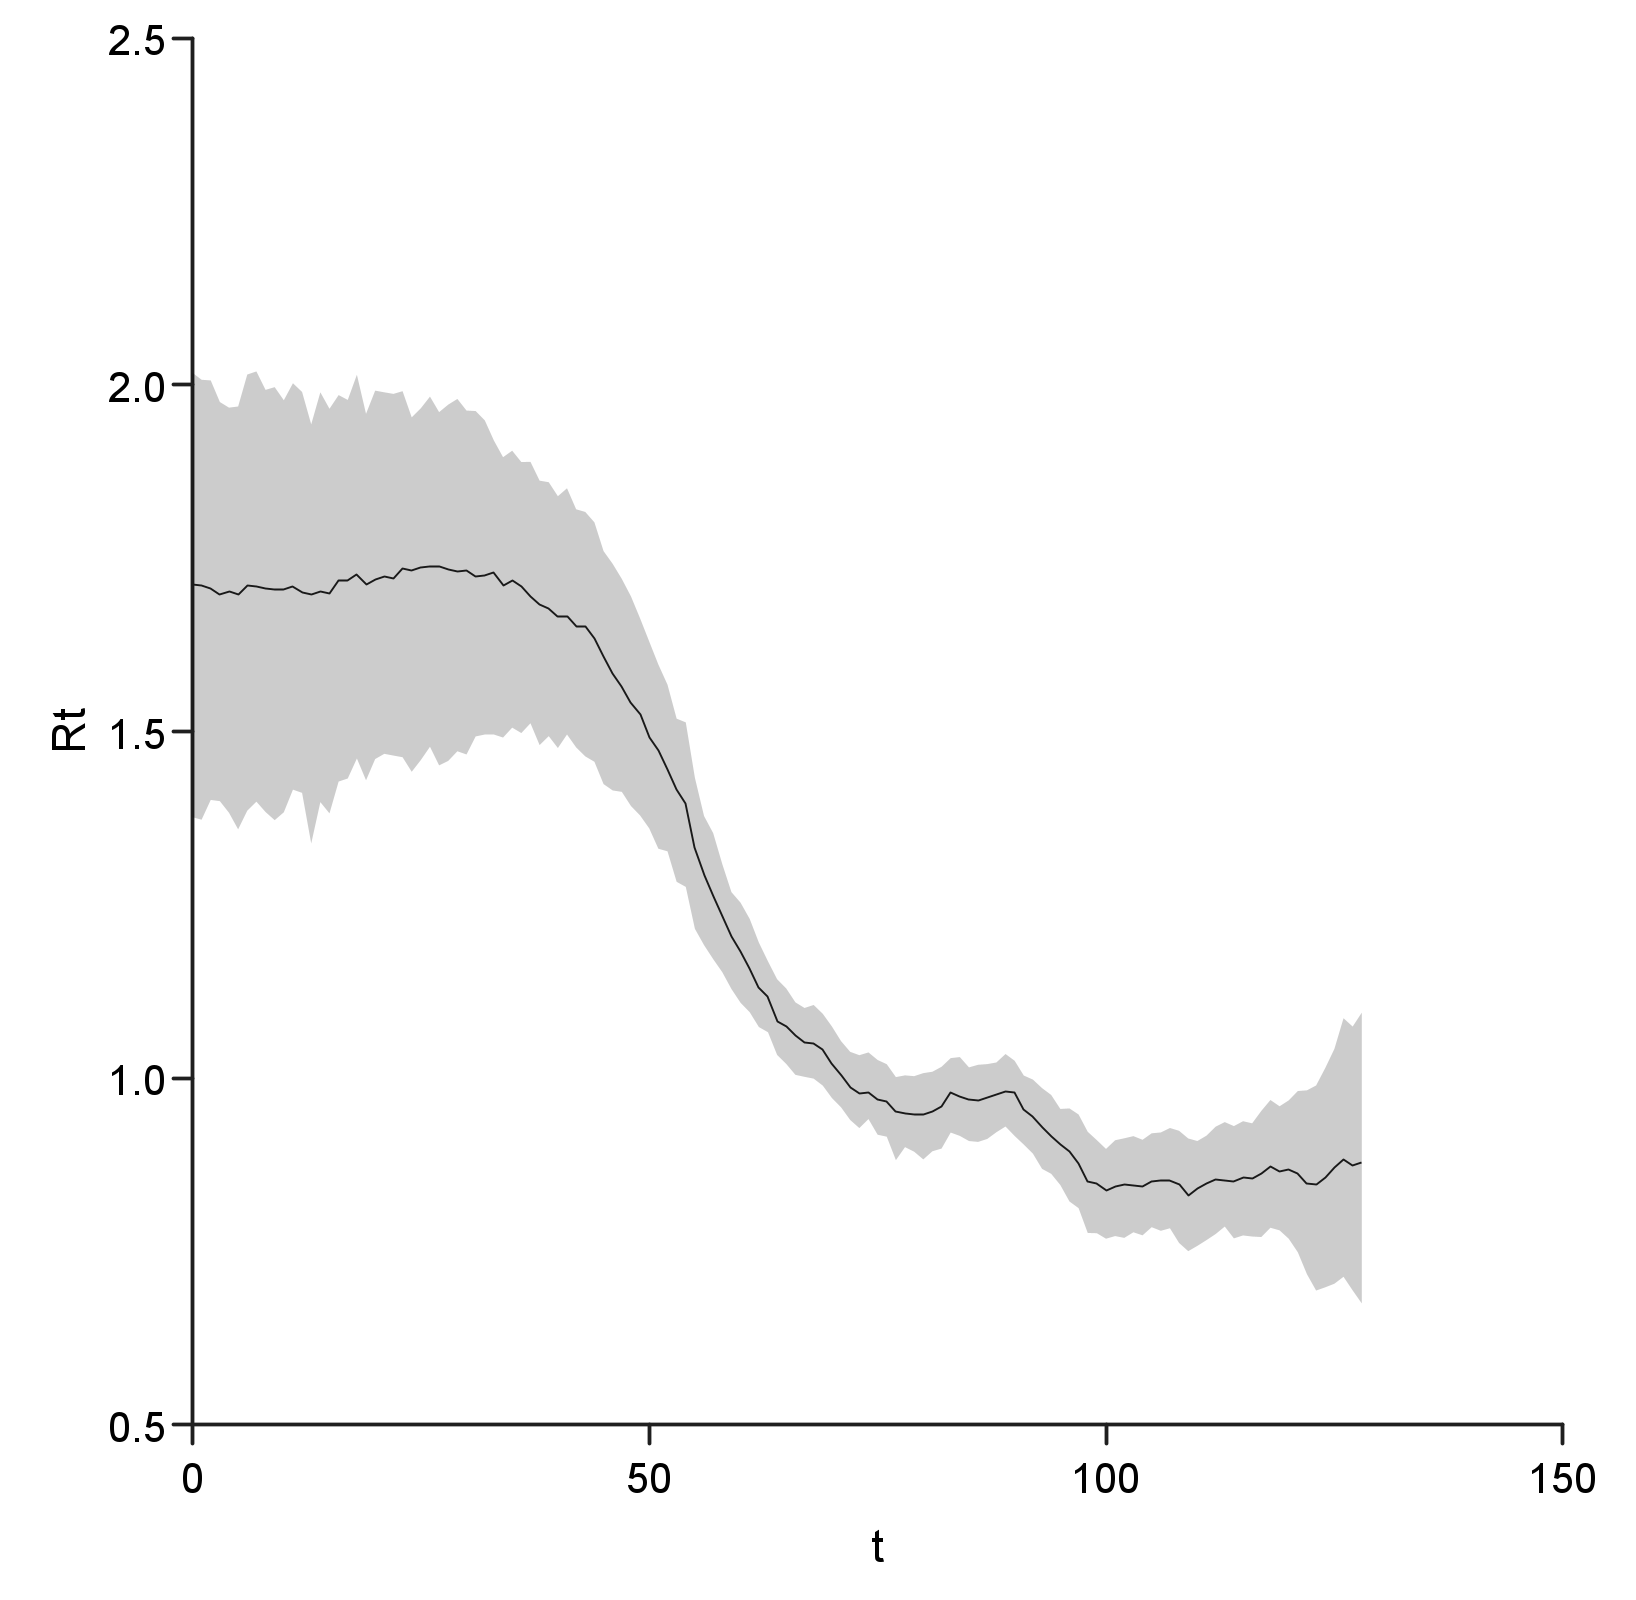

In [45]:
// {{
//     val countryName = "United_Kingdom"
//     val onsetNumbers = countriesOnsetData.collect {
//         case m if m("country") == countryName => m("Onset").toDouble.round
//     }
//     val RtModelEstimates(rts,estimates,_, _) = time { 
//         val (res, log) = predictRt(onsetNumbers, pdelay, failedRunDetection = true)
//         processLogs(countryName, log)
//         res
//     }
//     val RtsDistributionStats(means, medians, hdpis_90, hdpis_50) = distributionStats(rts, estimates)
//     // show("t", "Rt", line(means), shade(hdpis_50))
//     show("t", "Rt", line(means), shade(hdpis_90))
// }}

In [31]:
//val countriesToPredict = Seq("Poland", "France", "Italy") // Smaller set
val countriesToPredict = countriesOnsetData.map(_("country")).toSet  // Full set

countriesToPredict: Set[String] = Set(
  "Poland",
  "Croatia",
  "Luxembourg",
  "Greece",
  "Spain",
  "Russia",
  "Estonia",
  "Czechia",
  "Romania",
  "Denmark",
  "Belgium",
  "Slovenia",
  "Malta",
  "Belarus",
  "Slovakia",
  "Finland",
  "Lithuania",
  "Sweden",
  "United_Kingdom",
  "Austria",
  "Latvia",
  "Italy",
  "Ireland",
  "Bulgaria",
  "Norway",
  "France",
  "Netherlands",
  "Switzerland",
  "Cyprus",
  "Germany",
  "Portugal",
  "Hungary"
)

In [32]:
val countryStats: Map[String, Either[Throwable, RtsDistributionStats]] = {
    assert(countriesToPredict.toSet.subsetOf(countriesOnsetData.map(_("country")).toSet))
    val allStats = time {
        countriesToPredict.par.map { countryName =>
            val caseNumbers = countriesOnsetData.collect {
                case m if m("country") == countryName => m("Onset").toDouble.round
            }
            val possiblyFailed: Try[RtsDistributionStats] = Try { 
                val (rtme, logs) = predictRt(caseNumbers, pdelay, failedRunDetection = true)
                processLogs(countryName, logs)
                val RtModelEstimates(rts,estimates, serialInterval, serialEstimates) = rtme
                val stats@RtsDistributionStats(means, medians, hdpis_90, hdpis_50) = distributionStats(rts, estimates)
                println(s"$countryName [done]")
                stats
            }
            countryName -> possiblyFailed.toEither
        }.seq
    }
    allStats.toMap
}

Chain 1 Complete : Iteration: 50 (36ms) Acceptance rate: 0.78 E-BFMI: 0.83 Step size: 0.03 Total gradient evaluations: 1e+04 (114us) Total time: 6s

Chain 1 Complete : Iteration: 50 (55ms) Acceptance rate: 0.95 E-BFMI: 0.86 Step size: 0.008 Total gradient evaluations: 1e+04 (229us) Total time: 8s

Chain 1 Complete : Iteration: 50 (70ms) Acceptance rate: 0.98 E-BFMI: 1.53 Step size: 0.003 Total gradient evaluations: 1e+04 (342us) Total time: 10s

Chain 1 Complete : Iteration: 50 (86ms) Acceptance rate: 0.87 E-BFMI: 0.84 Step size: 0.004 Total gradient evaluations: 1e+04 (524us) Total time: 12s

Chain 2 Complete : Iteration: 50 (32ms) Acceptance rate: 0.89 E-BFMI: 0.35 Step size: 0.03 Total gradient evaluations: 1e+04 (184us) Total time: 3s

Chain 2 Complete : Iteration: 50 (48ms) Acceptance rate: 0.97 E-BFMI: 1.11 Step size: 0.007 Total gradient evaluations: 1e+04 (224us) Total time: 4s

WARN: Attempt[1] failed. Retrying...


Chain 1 Complete : Iteration: 50 (29ms) Acceptance rate: 0.83 E-BFMI: 0.67 Step size: 0.03 Total gradient evaluations: 1e+04 (137us) Total time: 3s

Chain 2 Complete : Iteration: 50 (78ms) Acceptance rate: 0.94 E-BFMI: 1.62 Step size: 0.003 Total gradient evaluations: 1e+04 (561us) Total time: 7s

Chain 2 Complete : Iteration: 50 (29ms) Acceptance rate: 0.87 E-BFMI: 0.91 Step size: 0.03 Total gradient evaluations: 1e+04 (141us) Total time: 2s

Chain 2 Complete : Iteration: 50 (89ms) Acceptance rate: 0.90 E-BFMI: 1.45 Step size: 0.003 Total gradient evaluations: 1e+04 (428us) Total time: 9s

WARN: Attempt[1] failed. Retrying...


Chain 1 Complete : Iteration: 50 (53ms) Acceptance rate: 0.93 E-BFMI: 0.68 Step size: 0.009 Total gradient evaluations: 1e+04 (259us) Total time: 5s

Success in [2] iteration.
Slovakia [done]


Chain 1 Complete : Iteration: 50 (38ms) Acceptance rate: 0.92 E-BFMI: 0.55 Step size: 0.02 Total gradient evaluations: 1e+04 (178us) Total time: 4s

WARN: Attempt[1] failed. Retrying...


Chain 1 Complete : Iteration: 50 (65ms) Acceptance rate: 0.93 E-BFMI: 1.87 Step size: 0.002 Total gradient evaluations: 1e+04 (321us) Total time: 6s

Chain 2 Complete : Iteration: 50 (49ms) Acceptance rate: 0.96 E-BFMI: 0.82 Step size: 0.008 Total gradient evaluations: 1e+04 (233us) Total time: 5s

Chain 2 Complete : Iteration: 50 (37ms) Acceptance rate: 0.95 E-BFMI: 0.93 Step size: 0.02 Total gradient evaluations: 1e+04 (181us) Total time: 3s

WARN: Attempt[1] failed. Retrying...


Chain 1 Complete : Iteration: 50 (87ms) Acceptance rate: 0.76 E-BFMI: 1.84 Step size: 0.0004 Total gradient evaluations: 1e+04 (473us) Total time: 8s

WARN: Attempt[2] failed. Retrying...


Chain 1 Complete : Iteration: 50 (48ms) Acceptance rate: 0.97 E-BFMI: 0.93 Step size: 0.007 Total gradient evaluations: 1e+04 (229us) Total time: 4s

Chain 2 Complete : Iteration: 50 (64ms) Acceptance rate: 0.94 E-BFMI: 1.06 Step size: 0.003 Total gradient evaluations: 1e+04 (315us) Total time: 6s

WARN: Attempt[1] failed. Retrying...


Chain 1 Complete : Iteration: 50 (36ms) Acceptance rate: 0.90 E-BFMI: 0.68 Step size: 0.02 Total gradient evaluations: 1e+04 (192us) Total time: 3s

Chain 2 Complete : Iteration: 50 (46ms) Acceptance rate: 0.93 E-BFMI: 0.96 Step size: 0.01 Total gradient evaluations: 1e+04 (228us) Total time: 4s

Chain 2 Complete : Iteration: 50 (38ms) Acceptance rate: 0.89 E-BFMI: 0.79 Step size: 0.02 Total gradient evaluations: 1e+04 (180us) Total time: 3s

WARN: Attempt[2] failed. Retrying...


Chain 1 Complete : Iteration: 50 (76ms) Acceptance rate: 0.96 E-BFMI: 1.11 Step size: 0.003 Total gradient evaluations: 1e+04 (319us) Total time: 7s

Chain 2 Complete : Iteration: 50 (91ms) Acceptance rate: 0.86 E-BFMI: 0.64 Step size: 0.003 Total gradient evaluations: 1e+04 (615us) Total time: 9s

WARN: Attempt[2] failed. Retrying...


Chain 1 Complete : Iteration: 50 (43ms) Acceptance rate: 0.91 E-BFMI: 0.61 Step size: 0.02 Total gradient evaluations: 1e+04 (179us) Total time: 4s

WARN: Attempt[3] failed. Retrying...
Portugal [done]


Chain 1 Complete : Iteration: 50 (36ms) Acceptance rate: 0.85 E-BFMI: 0.83 Step size: 0.02 Total gradient evaluations: 1e+04 (170us) Total time: 4s

Chain 2 Complete : Iteration: 50 (37ms) Acceptance rate: 0.93 E-BFMI: 0.49 Step size: 0.02 Total gradient evaluations: 1e+04 (179us) Total time: 3s

Chain 2 Complete : Iteration: 50 (71ms) Acceptance rate: 0.93 E-BFMI: 1.59 Step size: 0.003 Total gradient evaluations: 1e+04 (309us) Total time: 6s

Chain 2 Complete : Iteration: 50 (41ms) Acceptance rate: 0.87 E-BFMI: 0.53 Step size: 0.02 Total gradient evaluations: 1e+04 (173us) Total time: 4s

WARN: Attempt[3] failed. Retrying...
WARN: Attempt[2] failed. Retrying...


Chain 1 Complete : Iteration: 50 (96ms) Acceptance rate: 0.96 E-BFMI: 0.54 Step size: 0.003 Total gradient evaluations: 1e+04 (420us) Total time: 10s

Finland [done]


Chain 1 Complete : Iteration: 50 (33ms) Acceptance rate: 0.95 E-BFMI: 0.60 Step size: 0.007 Total gradient evaluations: 1e+04 (148us) Total time: 4s

WARN: Attempt[1] failed. Retrying...


Chain 1 Complete : Iteration: 50 (39ms) Acceptance rate: 0.92 E-BFMI: 0.55 Step size: 0.02 Total gradient evaluations: 1e+04 (170us) Total time: 4s

WARN: Attempt[3] failed. Retrying...
United_Kingdom [done]


Chain 2 Complete : Iteration: 50 (33ms) Acceptance rate: 0.96 E-BFMI: 0.62 Step size: 0.008 Total gradient evaluations: 1e+04 (149us) Total time: 3s

Chain 1 Complete : Iteration: 50 (52ms) Acceptance rate: 0.90 E-BFMI: 0.81 Step size: 0.02 Total gradient evaluations: 1e+04 (242us) Total time: 6s

Chain 2 Complete : Iteration: 50 (36ms) Acceptance rate: 0.75 E-BFMI: 0.96 Step size: 0.03 Total gradient evaluations: 1e+04 (169us) Total time: 3s

WARN: Attempt[1] failed. Retrying...


Chain 1 Complete : Iteration: 50 (33ms) Acceptance rate: 0.95 E-BFMI: 1.44 Step size: 0.008 Total gradient evaluations: 1e+04 (148us) Total time: 3s

Chain 2 Complete : Iteration: 50 (95ms) Acceptance rate: 0.96 E-BFMI: 1.69 Step size: 0.002 Total gradient evaluations: 1e+04 (381us) Total time: 9s

WARN: Attempt[2] failed. Retrying...


Chain 1 Complete : Iteration: 50 (35ms) Acceptance rate: 0.91 E-BFMI: 0.71 Step size: 0.02 Total gradient evaluations: 1e+04 (172us) Total time: 3s

Chain 2 Complete : Iteration: 50 (31ms) Acceptance rate: 0.98 E-BFMI: 0.89 Step size: 0.006 Total gradient evaluations: 1e+04 (149us) Total time: 3s

Chain 2 Complete : Iteration: 50 (49ms) Acceptance rate: 0.95 E-BFMI: 1.35 Step size: 0.01 Total gradient evaluations: 1e+04 (243us) Total time: 4s

Chain 2 Complete : Iteration: 50 (35ms) Acceptance rate: 0.88 E-BFMI: 0.76 Step size: 0.03 Total gradient evaluations: 1e+04 (294us) Total time: 3s

WARN: Attempt[2] failed. Retrying...


Chain 1 Complete : Iteration: 50 (37ms) Acceptance rate: 0.95 E-BFMI: 1.16 Step size: 0.008 Total gradient evaluations: 1e+04 (150us) Total time: 3s

WARN: Attempt[1] failed. Retrying...


Chain 1 Complete : Iteration: 50 (58ms) Acceptance rate: 0.97 E-BFMI: 0.91 Step size: 0.008 Total gradient evaluations: 1e+04 (245us) Total time: 6s

WARN: Attempt[3] failed. Retrying...
Hungary [done]


Chain 2 Complete : Iteration: 50 (37ms) Acceptance rate: 0.93 E-BFMI: 1.38 Step size: 0.007 Total gradient evaluations: 1e+04 (152us) Total time: 3s

WARN: Attempt[3] failed. Retrying...


Chain 1 Complete : Iteration: 50 (32ms) Acceptance rate: 0.82 E-BFMI: 0.75 Step size: 0.03 Total gradient evaluations: 1e+04 (125us) Total time: 4s

Italy [done]


Chain 1 Complete : Iteration: 50 (50ms) Acceptance rate: 0.97 E-BFMI: 0.75 Step size: 0.007 Total gradient evaluations: 1e+04 (223us) Total time: 6s

WARN: Attempt[3] failed. Retrying...
Belarus [done]


Chain 2 Complete : Iteration: 50 (51ms) Acceptance rate: 0.92 E-BFMI: 0.54 Step size: 0.02 Total gradient evaluations: 1e+04 (262us) Total time: 5s

Chain 2 Complete : Iteration: 50 (28ms) Acceptance rate: 0.83 E-BFMI: 0.42 Step size: 0.04 Total gradient evaluations: 1e+04 (139us) Total time: 3s

Chain 1 Complete : Iteration: 50 (43ms) Acceptance rate: 0.90 E-BFMI: 0.68 Step size: 0.02 Total gradient evaluations: 1e+04 (170us) Total time: 5s

Success in [1] iteration.
Cyprus [done]


Chain 2 Complete : Iteration: 50 (56ms) Acceptance rate: 0.98 E-BFMI: 0.75 Step size: 0.009 Total gradient evaluations: 1e+04 (222us) Total time: 5s

WARN: Attempt[2] failed. Retrying...


Chain 1 Complete : Iteration: 50 (53ms) Acceptance rate: 0.97 E-BFMI: 0.61 Step size: 0.01 Total gradient evaluations: 1e+04 (255us) Total time: 5s

Chain 2 Complete : Iteration: 50 (41ms) Acceptance rate: 0.86 E-BFMI: 0.90 Step size: 0.03 Total gradient evaluations: 1e+04 (186us) Total time: 4s

Chain 1 Complete : Iteration: 50 (77ms) Acceptance rate: 0.98 E-BFMI: 0.55 Step size: 0.001 Total gradient evaluations: 1e+04 (376us) Total time: 9s

WARN: Attempt[1] failed. Retrying...


Chain 1 Complete : Iteration: 50 (47ms) Acceptance rate: 0.99 E-BFMI: 1.41 Step size: 0.002 Total gradient evaluations: 1e+04 (225us) Total time: 4s

WARN: Attempt[1] failed. Retrying...


Chain 1 Complete : Iteration: 50 (38ms) Acceptance rate: 0.86 E-BFMI: 0.72 Step size: 0.03 Total gradient evaluations: 1e+04 (181us) Total time: 3s

Chain 2 Complete : Iteration: 50 (49ms) Acceptance rate: 0.95 E-BFMI: 0.86 Step size: 0.01 Total gradient evaluations: 1e+04 (239us) Total time: 5s

Chain 2 Complete : Iteration: 50 (39ms) Acceptance rate: 0.86 E-BFMI: 1.09 Step size: 0.03 Total gradient evaluations: 1e+04 (179us) Total time: 3s

Chain 2 Complete : Iteration: 50 (58ms) Acceptance rate: 0.95 E-BFMI: 0.99 Step size: 0.01 Total gradient evaluations: 1e+04 (313us) Total time: 5s

Chain 2 Complete : Iteration: 50 (82ms) Acceptance rate: 0.97 E-BFMI: 1.06 Step size: 0.003 Total gradient evaluations: 1e+04 (371us) Total time: 8s

WARN: Attempt[3] failed. Retrying...
Austria [done]


Chain 1 Complete : Iteration: 50 (41ms) Acceptance rate: 0.92 E-BFMI: 0.65 Step size: 0.03 Total gradient evaluations: 1e+04 (190us) Total time: 5s

Success in [2] iteration.
Estonia [done]
WARN: Attempt[2] failed. Retrying...


Chain 1 Complete : Iteration: 50 (47ms) Acceptance rate: 0.95 E-BFMI: 1.02 Step size: 0.01 Total gradient evaluations: 1e+04 (220us) Total time: 5s

Chain 1 Complete : Iteration: 50 (46ms) Acceptance rate: 0.96 E-BFMI: 0.89 Step size: 0.01 Total gradient evaluations: 1e+04 (220us) Total time: 5s

Chain 2 Complete : Iteration: 50 (40ms) Acceptance rate: 0.87 E-BFMI: 0.65 Step size: 0.03 Total gradient evaluations: 1e+04 (193us) Total time: 4s

WARN: Attempt[1] failed. Retrying...


Chain 1 Complete : Iteration: 50 (94ms) Acceptance rate: 0.94 E-BFMI: 0.90 Step size: 0.005 Total gradient evaluations: 1e+04 (411us) Total time: 8s

Chain 2 Complete : Iteration: 50 (45ms) Acceptance rate: 0.90 E-BFMI: 0.07 Step size: 0.0001 Total gradient evaluations: 1e+04 (225us) Total time: 4s

Chain 2 Complete : Iteration: 50 (54ms) Acceptance rate: 0.94 E-BFMI: 1.10 Step size: 0.02 Total gradient evaluations: 1e+04 (206us) Total time: 5s

Success in [1] iteration.
Lithuania [done]
WARN: Attempt[3] failed. Retrying...


Chain 1 Complete : Iteration: 50 (50ms) Acceptance rate: 0.95 E-BFMI: 1.67 Step size: 0.007 Total gradient evaluations: 1e+04 (256us) Total time: 6s

Ireland [done]


Chain 1 Complete : Iteration: 50 (29ms) Acceptance rate: 0.86 E-BFMI: 0.38 Step size: 0.03 Total gradient evaluations: 1e+04 (137us) Total time: 3s

WARN: Attempt[1] failed. Retrying...


Chain 1 Complete : Iteration: 50 (46ms) Acceptance rate: 0.88 E-BFMI: 0.80 Step size: 0.02 Total gradient evaluations: 1e+04 (217us) Total time: 4s

Chain 2 Complete : Iteration: 50 (75ms) Acceptance rate: 0.87 E-BFMI: 0.65 Step size: 0.004 Total gradient evaluations: 1e+04 (371us) Total time: 7s

Chain 2 Complete : Iteration: 50 (29ms) Acceptance rate: 0.83 E-BFMI: 0.69 Step size: 0.03 Total gradient evaluations: 1e+04 (140us) Total time: 2s

Chain 2 Complete : Iteration: 50 (24ms) Acceptance rate: 0.95 E-BFMI: 0.79 Step size: 0.02 Total gradient evaluations: 1e+04 (120us) Total time: 3s

Chain 2 Complete : Iteration: 50 (44ms) Acceptance rate: 0.95 E-BFMI: 0.74 Step size: 0.008 Total gradient evaluations: 1e+04 (221us) Total time: 4s

Success in [1] iteration.
Latvia [done]
WARN: Attempt[2] failed. Retrying...


Chain 1 Complete : Iteration: 50 (25ms) Acceptance rate: 0.92 E-BFMI: 1.43 Step size: 0.02 Total gradient evaluations: 1e+04 (122us) Total time: 2s

WARN: Attempt[2] failed. Retrying...


Chain 1 Complete : Iteration: 50 (62ms) Acceptance rate: 0.98 E-BFMI: 2.06 Step size: 0.003 Total gradient evaluations: 1e+04 (214us) Total time: 6s

WARN: Attempt[1] failed. Retrying...


Chain 1 Complete : Iteration: 50 (45ms) Acceptance rate: 0.97 E-BFMI: 0.71 Step size: 0.007 Total gradient evaluations: 1e+04 (223us) Total time: 4s

Chain 2 Complete : Iteration: 50 (25ms) Acceptance rate: 0.89 E-BFMI: 0.71 Step size: 0.02 Total gradient evaluations: 1e+04 (120us) Total time: 2s

WARN: Attempt[3] failed. Retrying...
Czechia [done]


Chain 2 Complete : Iteration: 50 (45ms) Acceptance rate: 0.95 E-BFMI: 0.73 Step size: 0.007 Total gradient evaluations: 1e+04 (225us) Total time: 4s

Chain 1 Complete : Iteration: 50 (38ms) Acceptance rate: 0.94 E-BFMI: 0.35 Step size: 0.0001 Total gradient evaluations: 1e+04 (190us) Total time: 4s

Chain 2 Complete : Iteration: 50 (75ms) Acceptance rate: 0.95 E-BFMI: 1.09 Step size: 0.004 Total gradient evaluations: 1e+04 (370us) Total time: 5s

Chain 2 Complete : Iteration: 50 (38ms) Acceptance rate: 0.97 E-BFMI: 1.30 Step size: 0.008 Total gradient evaluations: 1e+04 (464us) Total time: 3s

WARN: Attempt[2] failed. Retrying...


Chain 1 Complete : Iteration: 50 (25ms) Acceptance rate: 0.98 E-BFMI: 0.59 Step size: 0.007 Total gradient evaluations: 1e+04 (124us) Total time: 2s

Chain 2 Complete : Iteration: 50 (36ms) Acceptance rate: 0.98 E-BFMI: 0.98 Step size: 0.008 Total gradient evaluations: 1e+04 (225us) Total time: 3s

WARN: Attempt[3] failed. Retrying...
WARN: Attempt[1] failed. Retrying...


Chain 1 Complete : Iteration: 50 (47ms) Acceptance rate: 0.94 E-BFMI: 0.36 Step size: 0.01 Total gradient evaluations: 1e+04 (173us) Total time: 4s

Germany [done]


Chain 1 Complete : Iteration: 50 (78ms) Acceptance rate: 0.96 E-BFMI: 0.83 Step size: 0.01 Total gradient evaluations: 1e+04 (353us) Total time: 9s

WARN: Attempt[3] failed. Retrying...
Sweden [done]


Chain 2 Complete : Iteration: 50 (44ms) Acceptance rate: 0.95 E-BFMI: 0.71 Step size: 0.01 Total gradient evaluations: 1e+04 (189us) Total time: 4s

Chain 1 Complete : Iteration: 50 (53ms) Acceptance rate: 0.93 E-BFMI: 0.59 Step size: 0.02 Total gradient evaluations: 1e+04 (235us) Total time: 6s

Chain 1 Complete : Iteration: 50 (60ms) Acceptance rate: 0.94 E-BFMI: 0.74 Step size: 0.006 Total gradient evaluations: 1e+04 (284us) Total time: 7s

WARN: Attempt[2] failed. Retrying...


Chain 1 Complete : Iteration: 50 (40ms) Acceptance rate: 0.94 E-BFMI: 0.75 Step size: 0.01 Total gradient evaluations: 1e+04 (191us) Total time: 4s

Chain 2 Complete : Iteration: 50 (72ms) Acceptance rate: 0.80 E-BFMI: 2.27 Step size: 0.0008 Total gradient evaluations: 1e+04 (354us) Total time: 7s

Chain 2 Complete : Iteration: 50 (48ms) Acceptance rate: 0.90 E-BFMI: 0.57 Step size: 0.02 Total gradient evaluations: 1e+04 (235us) Total time: 4s

Chain 2 Complete : Iteration: 50 (58ms) Acceptance rate: 0.82 E-BFMI: 0.92 Step size: 0.01 Total gradient evaluations: 1e+04 (278us) Total time: 5s

Chain 2 Complete : Iteration: 50 (38ms) Acceptance rate: 0.91 E-BFMI: 0.67 Step size: 0.01 Total gradient evaluations: 1e+04 (190us) Total time: 3s

WARN: Attempt[1] failed. Retrying...


Chain 1 Complete : Iteration: 50 (61ms) Acceptance rate: 0.89 E-BFMI: 0.83 Step size: 0.02 Total gradient evaluations: 1e+04 (233us) Total time: 5s

WARN: Attempt[3] failed. Retrying...
Romania [done]
WARN: Attempt[1] failed. Retrying...


Chain 1 Complete : Iteration: 50 (57ms) Acceptance rate: 0.96 E-BFMI: 1.15 Step size: 0.007 Total gradient evaluations: 1e+04 (277us) Total time: 6s

WARN: Attempt[1] failed. Retrying...


Chain 1 Complete : Iteration: 50 (72ms) Acceptance rate: 0.95 E-BFMI: 0.75 Step size: 0.009 Total gradient evaluations: 1e+04 (372us) Total time: 7s

Chain 1 Complete : Iteration: 50 (61ms) Acceptance rate: 0.94 E-BFMI: 0.65 Step size: 0.02 Total gradient evaluations: 1e+04 (294us) Total time: 7s

Chain 2 Complete : Iteration: 50 (48ms) Acceptance rate: 0.90 E-BFMI: 0.53 Step size: 0.02 Total gradient evaluations: 1e+04 (232us) Total time: 4s

Chain 2 Complete : Iteration: 50 (57ms) Acceptance rate: 0.94 E-BFMI: 0.67 Step size: 0.008 Total gradient evaluations: 1e+04 (279us) Total time: 5s

Chain 2 Complete : Iteration: 50 (75ms) Acceptance rate: 0.86 E-BFMI: 0.65 Step size: 0.01 Total gradient evaluations: 1e+04 (379us) Total time: 7s

Chain 2 Complete : Iteration: 50 (61ms) Acceptance rate: 0.93 E-BFMI: 1.23 Step size: 0.02 Total gradient evaluations: 1e+04 (299us) Total time: 6s

WARN: Attempt[2] failed. Retrying...


Chain 1 Complete : Iteration: 50 (47ms) Acceptance rate: 0.91 E-BFMI: 1.16 Step size: 0.02 Total gradient evaluations: 1e+04 (235us) Total time: 4s

WARN: Attempt[2] failed. Retrying...


Chain 1 Complete : Iteration: 50 (60ms) Acceptance rate: 0.87 E-BFMI: 0.37 Step size: 0.007 Total gradient evaluations: 1e+04 (279us) Total time: 5s

Chain 2 Complete : Iteration: 50 (49ms) Acceptance rate: 0.94 E-BFMI: 0.96 Step size: 0.02 Total gradient evaluations: 1e+04 (239us) Total time: 4s

WARN: Attempt[1] failed. Retrying...


Chain 1 Complete : Iteration: 50 (68ms) Acceptance rate: 0.96 E-BFMI: 1.13 Step size: 0.01 Total gradient evaluations: 1e+04 (312us) Total time: 6s

WARN: Attempt[2] failed. Retrying...


Chain 1 Complete : Iteration: 50 (85ms) Acceptance rate: 0.95 E-BFMI: 0.55 Step size: 0.01 Total gradient evaluations: 1e+04 (374us) Total time: 8s

Chain 2 Complete : Iteration: 50 (56ms) Acceptance rate: 0.96 E-BFMI: 0.68 Step size: 0.007 Total gradient evaluations: 1e+04 (279us) Total time: 5s

WARN: Attempt[3] failed. Retrying...
Norway [done]


Jun 03, 2020 6:30:28 PM com.stripe.rainier.compute.Bounds$ warn


Chain 1 Complete : Iteration: 50 (34ms) Acceptance rate: 0.87 E-BFMI: 0.75 Step size: 0.03 Total gradient evaluations: 1e+04 (160us) Total time: 4s

Chain 2 Complete : Iteration: 50 (58ms) Acceptance rate: 0.94 E-BFMI: 0.45 Step size: 0.01 Total gradient evaluations: 1e+04 (289us) Total time: 6s

Chain 2 Complete : Iteration: 50 (32ms) Acceptance rate: 0.92 E-BFMI: 0.87 Step size: 0.02 Total gradient evaluations: 1e+04 (158us) Total time: 3s

WARN: Attempt[3] failed. Retrying...


Chain 2 Complete : Iteration: 50 (57ms) Acceptance rate: 0.96 E-BFMI: 0.70 Step size: 0.006 Total gradient evaluations: 1e+04 (409us) Total time: 5s

Netherlands [done]
WARN: Attempt[2] failed. Retrying...


Chain 1 Complete : Iteration: 50 (59ms) Acceptance rate: 0.94 E-BFMI: 0.54 Step size: 0.02 Total gradient evaluations: 1e+04 (296us) Total time: 6s

Success in [1] iteration.
Bulgaria [done]


Chain 1 Complete : Iteration: 50 (28ms) Acceptance rate: 0.90 E-BFMI: 0.66 Step size: 0.03 Total gradient evaluations: 1e+04 (112us) Total time: 4s

WARN: Attempt[3] failed. Retrying...
Switzerland [done]


Chain 1 Complete : Iteration: 50 (68ms) Acceptance rate: 0.95 E-BFMI: 1.33 Step size: 0.004 Total gradient evaluations: 1e+04 (300us) Total time: 8s

Chain 2 Complete : Iteration: 50 (35ms) Acceptance rate: 0.93 E-BFMI: 0.52 Step size: 0.01 Total gradient evaluations: 1e+04 (294us) Total time: 4s

Chain 2 Complete : Iteration: 50 (30ms) Acceptance rate: 0.92 E-BFMI: 0.81 Step size: 0.02 Total gradient evaluations: 1e+04 (202us) Total time: 2s

WARN: Attempt[1] failed. Retrying...


Chain 1 Complete : Iteration: 50 (23ms) Acceptance rate: 0.92 E-BFMI: 0.57 Step size: 0.02 Total gradient evaluations: 1e+04 (110us) Total time: 2s

WARN: Attempt[3] failed. Retrying...
Denmark [done]


Chain 2 Complete : Iteration: 50 (57ms) Acceptance rate: 0.96 E-BFMI: 1.70 Step size: 0.002 Total gradient evaluations: 1e+04 (196us) Total time: 6s

Chain 2 Complete : Iteration: 50 (23ms) Acceptance rate: 0.88 E-BFMI: 0.69 Step size: 0.02 Total gradient evaluations: 1e+04 (118us) Total time: 3s

Chain 1 Complete : Iteration: 50 (54ms) Acceptance rate: 0.75 E-BFMI: 0.41 Step size: 0.008 Total gradient evaluations: 1e+04 (266us) Total time: 6s

WARN: Attempt[2] failed. Retrying...


Chain 1 Complete : Iteration: 50 (31ms) Acceptance rate: 0.89 E-BFMI: 0.47 Step size: 0.03 Total gradient evaluations: 1e+04 (129us) Total time: 2s

WARN: Attempt[1] failed. Retrying...


Chain 1 Complete : Iteration: 50 (66ms) Acceptance rate: 0.98 E-BFMI: 0.99 Step size: 0.002 Total gradient evaluations: 1e+04 (341us) Total time: 6s

Chain 2 Complete : Iteration: 50 (23ms) Acceptance rate: 0.92 E-BFMI: 0.93 Step size: 0.02 Total gradient evaluations: 1e+04 (111us) Total time: 2s

Chain 2 Complete : Iteration: 50 (53ms) Acceptance rate: 0.94 E-BFMI: 0.77 Step size: 0.005 Total gradient evaluations: 1e+04 (265us) Total time: 5s

WARN: Attempt[3] failed. Retrying...
Luxembourg [done]


Chain 1 Complete : Iteration: 50 (24ms) Acceptance rate: 0.86 E-BFMI: 0.89 Step size: 0.03 Total gradient evaluations: 1e+04 (111us) Total time: 3s

WARN: Attempt[1] failed. Retrying...


Chain 1 Complete : Iteration: 50 (53ms) Acceptance rate: 0.97 E-BFMI: 1.16 Step size: 0.005 Total gradient evaluations: 1e+04 (265us) Total time: 5s

Chain 2 Complete : Iteration: 50 (63ms) Acceptance rate: 0.96 E-BFMI: 1.61 Step size: 0.004 Total gradient evaluations: 1e+04 (340us) Total time: 6s

Chain 2 Complete : Iteration: 50 (25ms) Acceptance rate: 0.83 E-BFMI: 0.68 Step size: 0.03 Total gradient evaluations: 1e+04 (110us) Total time: 2s

Success in [1] iteration.
Greece [done]


Chain 1 Complete : Iteration: 50 (21ms) Acceptance rate: 0.91 E-BFMI: 1.68 Step size: 0.03 Total gradient evaluations: 1e+04 (94us) Total time: 2s

Chain 2 Complete : Iteration: 50 (58ms) Acceptance rate: 0.93 E-BFMI: 0.64 Step size: 0.007 Total gradient evaluations: 1e+04 (251us) Total time: 5s

WARN: Attempt[2] failed. Retrying...


Chain 1 Complete : Iteration: 50 (61ms) Acceptance rate: 0.98 E-BFMI: 1.36 Step size: 0.003 Total gradient evaluations: 1e+04 (346us) Total time: 6s

Chain 2 Complete : Iteration: 50 (19ms) Acceptance rate: 0.92 E-BFMI: 0.47 Step size: 0.03 Total gradient evaluations: 1e+04 (93us) Total time: 1s

Success in [1] iteration.
Croatia [done]


Chain 1 Complete : Iteration: 50 (39ms) Acceptance rate: 0.95 E-BFMI: 0.45 Step size: 0.01 Total gradient evaluations: 1e+04 (196us) Total time: 4s

WARN: Attempt[2] failed. Retrying...


Chain 1 Complete : Iteration: 50 (31ms) Acceptance rate: 0.94 E-BFMI: 1.72 Step size: 0.006 Total gradient evaluations: 1e+04 (147us) Total time: 4s

Chain 2 Complete : Iteration: 50 (65ms) Acceptance rate: 0.92 E-BFMI: 1.37 Step size: 0.004 Total gradient evaluations: 1e+04 (191us) Total time: 6s

Chain 2 Complete : Iteration: 50 (39ms) Acceptance rate: 0.94 E-BFMI: 0.83 Step size: 0.01 Total gradient evaluations: 1e+04 (195us) Total time: 3s

Chain 2 Complete : Iteration: 50 (31ms) Acceptance rate: 0.93 E-BFMI: 1.02 Step size: 0.005 Total gradient evaluations: 1e+04 (157us) Total time: 3s

WARN: Attempt[3] failed. Retrying...
Belgium [done]
WARN: Attempt[1] failed. Retrying...


Chain 1 Complete : Iteration: 50 (27ms) Acceptance rate: 0.96 E-BFMI: 0.68 Step size: 0.009 Total gradient evaluations: 1e+04 (108us) Total time: 3s

Chain 1 Complete : Iteration: 50 (35ms) Acceptance rate: 0.91 E-BFMI: 0.51 Step size: 0.02 Total gradient evaluations: 1e+04 (168us) Total time: 4s

WARN: Attempt[3] failed. Retrying...
Spain [done]


Chain 2 Complete : Iteration: 50 (40ms) Acceptance rate: 0.94 E-BFMI: 0.85 Step size: 0.008 Total gradient evaluations: 1e+04 (198us) Total time: 4s

Chain 1 Complete : Iteration: 50 (35ms) Acceptance rate: 0.96 E-BFMI: 1.26 Step size: 0.003 Total gradient evaluations: 1e+04 (160us) Total time: 4s

Chain 2 Complete : Iteration: 50 (34ms) Acceptance rate: 0.86 E-BFMI: 0.70 Step size: 0.03 Total gradient evaluations: 1e+04 (170us) Total time: 3s

WARN: Attempt[2] failed. Retrying...


Chain 1 Complete : Iteration: 50 (42ms) Acceptance rate: 0.94 E-BFMI: 0.89 Step size: 0.01 Total gradient evaluations: 1e+04 (193us) Total time: 4s

Chain 2 Complete : Iteration: 50 (33ms) Acceptance rate: 0.95 E-BFMI: 1.40 Step size: 0.002 Total gradient evaluations: 1e+04 (157us) Total time: 4s

Success in [1] iteration.
Slovenia [done]


Chain 1 Complete : Iteration: 50 (38ms) Acceptance rate: 0.86 E-BFMI: 0.82 Step size: 0.03 Total gradient evaluations: 1e+04 (190us) Total time: 4s

Chain 2 Complete : Iteration: 50 (39ms) Acceptance rate: 0.93 E-BFMI: 0.65 Step size: 0.01 Total gradient evaluations: 1e+04 (196us) Total time: 3s

WARN: Attempt[1] failed. Retrying...


Chain 1 Complete : Iteration: 50 (34ms) Acceptance rate: 0.89 E-BFMI: 1.53 Step size: 0.004 Total gradient evaluations: 1e+04 (160us) Total time: 3s

Chain 2 Complete : Iteration: 50 (20ms) Acceptance rate: 0.84 E-BFMI: 1.04 Step size: 0.03 Total gradient evaluations: 1e+04 (102us) Total time: 2s

WARN: Attempt[3] failed. Retrying...


Chain 2 Complete : Iteration: 50 (31ms) Acceptance rate: 0.95 E-BFMI: 0.90 Step size: 0.003 Total gradient evaluations: 1e+04 (156us) Total time: 3s

Poland [done]
Success in [1] iteration.
Malta [done]
WARN: Attempt[2] failed. Retrying...


Chain 1 Complete : Iteration: 50 (31ms) Acceptance rate: 0.95 E-BFMI: 1.49 Step size: 0.003 Total gradient evaluations: 1e+04 (156us) Total time: 3s

Chain 2 Complete : Iteration: 50 (31ms) Acceptance rate: 0.94 E-BFMI: 1.06 Step size: 0.003 Total gradient evaluations: 1e+04 (156us) Total time: 3s

WARN: Attempt[3] failed. Retrying...
Russia [done]
Elapsed time: 235981 ms


countryStats: Map[String, Either[Throwable, RtsDistributionStats]] = Map(
  "Poland" -> Right(
    RtsDistributionStats(
      Vector(
        (0, 1.4476848021692852),
        (1, 1.4494785643038641),
        (2, 1.4497692442141572),
        (3, 1.4434064308201093),
        (4, 1.4433473382160862),
        (5, 1.4321460666979866),
        (6, 1.4370457506068948),
        (7, 1.4473251163935155),
        (8, 1.4437361016147219),
        (9, 1.45408878089044),
        (10, 1.4420060682439995),
        (11, 1.4515710010230718),
        (12, 1.4468073113223556),
        (13, 1.4377298927377877),
        (14, 1.455324494388193),
        (15, 1.4659865646643728),
        (16, 1.456864711658796),
        (17, 1.4543241298617202),
        (18, 1.447185763387521),
        (19, 1.450025091031524),
        (20, 1.4433575345035699),
        (21, 1.4386536595901698),
        (22, 1.435020388473744),
        (23, 1.4168774575449898),
        (24, 1.4337250427565846),
        (25, 1.4262019536472326)

In [34]:
countryStats

res33: Map[String, Either[Throwable, RtsDistributionStats]] = Map(
  "Poland" -> Right(
    RtsDistributionStats(
      Vector(
        (0, 1.4476848021692852),
        (1, 1.4494785643038641),
        (2, 1.4497692442141572),
        (3, 1.4434064308201093),
        (4, 1.4433473382160862),
        (5, 1.4321460666979866),
        (6, 1.4370457506068948),
        (7, 1.4473251163935155),
        (8, 1.4437361016147219),
        (9, 1.45408878089044),
        (10, 1.4420060682439995),
        (11, 1.4515710010230718),
        (12, 1.4468073113223556),
        (13, 1.4377298927377877),
        (14, 1.455324494388193),
        (15, 1.4659865646643728),
        (16, 1.456864711658796),
        (17, 1.4543241298617202),
        (18, 1.447185763387521),
        (19, 1.450025091031524),
        (20, 1.4433575345035699),
        (21, 1.4386536595901698),
        (22, 1.435020388473744),
        (23, 1.4168774575449898),
        (24, 1.4337250427565846),
        (25, 1.4262019536472326),
     

In [34]:
// val failedToConverge = countryStats collect {
//     case (countryName, res) if res.isLeft => countryName
// } 

In [34]:
// val countriesTriedOneMoreTime = failedToConverge.toSeq map { countryName =>
//     println(countryName)
//     val onsetNumbers = countriesOnsetData.collect {
//         case m if m("country") == countryName => m("Onset").toDouble.round
//     }
//     val RtModelEstimates(rts, estimates, serialInterval, serialEstimates) = time { 
//         val (res, logs) = predictRt(onsetNumbers, pdelay, failedRunDetection = false)
//         processLogs(countryName, logs)
//         res
//     }
//     countryName -> distributionStats(rts, estimates)
// }

In [35]:
val finalCountryStats = (countryStats collect {
    case (countryName, Right(stats)) => countryName -> stats
})// ++ countriesTriedOneMoreTime

finalCountryStats: Map[String, RtsDistributionStats] = Map(
  "Poland" -> RtsDistributionStats(
    Vector(
      (0, 1.4476848021692852),
      (1, 1.4494785643038641),
      (2, 1.4497692442141572),
      (3, 1.4434064308201093),
      (4, 1.4433473382160862),
      (5, 1.4321460666979866),
      (6, 1.4370457506068948),
      (7, 1.4473251163935155),
      (8, 1.4437361016147219),
      (9, 1.45408878089044),
      (10, 1.4420060682439995),
      (11, 1.4515710010230718),
      (12, 1.4468073113223556),
      (13, 1.4377298927377877),
      (14, 1.455324494388193),
      (15, 1.4659865646643728),
      (16, 1.456864711658796),
      (17, 1.4543241298617202),
      (18, 1.447185763387521),
      (19, 1.450025091031524),
      (20, 1.4433575345035699),
      (21, 1.4386536595901698),
      (22, 1.435020388473744),
      (23, 1.4168774575449898),
      (24, 1.4337250427565846),
      (25, 1.4262019536472326),
      (26, 1.4171542570411106),
      (27, 1.4161724260391209),
      (28, 1.

In [36]:
// override the previous variable so the rest of the notebook works fine
val countryStats = finalCountryStats

countryStats: Map[String, RtsDistributionStats] = Map(
  "Poland" -> RtsDistributionStats(
    Vector(
      (0, 1.4476848021692852),
      (1, 1.4494785643038641),
      (2, 1.4497692442141572),
      (3, 1.4434064308201093),
      (4, 1.4433473382160862),
      (5, 1.4321460666979866),
      (6, 1.4370457506068948),
      (7, 1.4473251163935155),
      (8, 1.4437361016147219),
      (9, 1.45408878089044),
      (10, 1.4420060682439995),
      (11, 1.4515710010230718),
      (12, 1.4468073113223556),
      (13, 1.4377298927377877),
      (14, 1.455324494388193),
      (15, 1.4659865646643728),
      (16, 1.456864711658796),
      (17, 1.4543241298617202),
      (18, 1.447185763387521),
      (19, 1.450025091031524),
      (20, 1.4433575345035699),
      (21, 1.4386536595901698),
      (22, 1.435020388473744),
      (23, 1.4168774575449898),
      (24, 1.4337250427565846),
      (25, 1.4262019536472326),
      (26, 1.4171542570411106),
      (27, 1.4161724260391209),
      (28, 1.39548

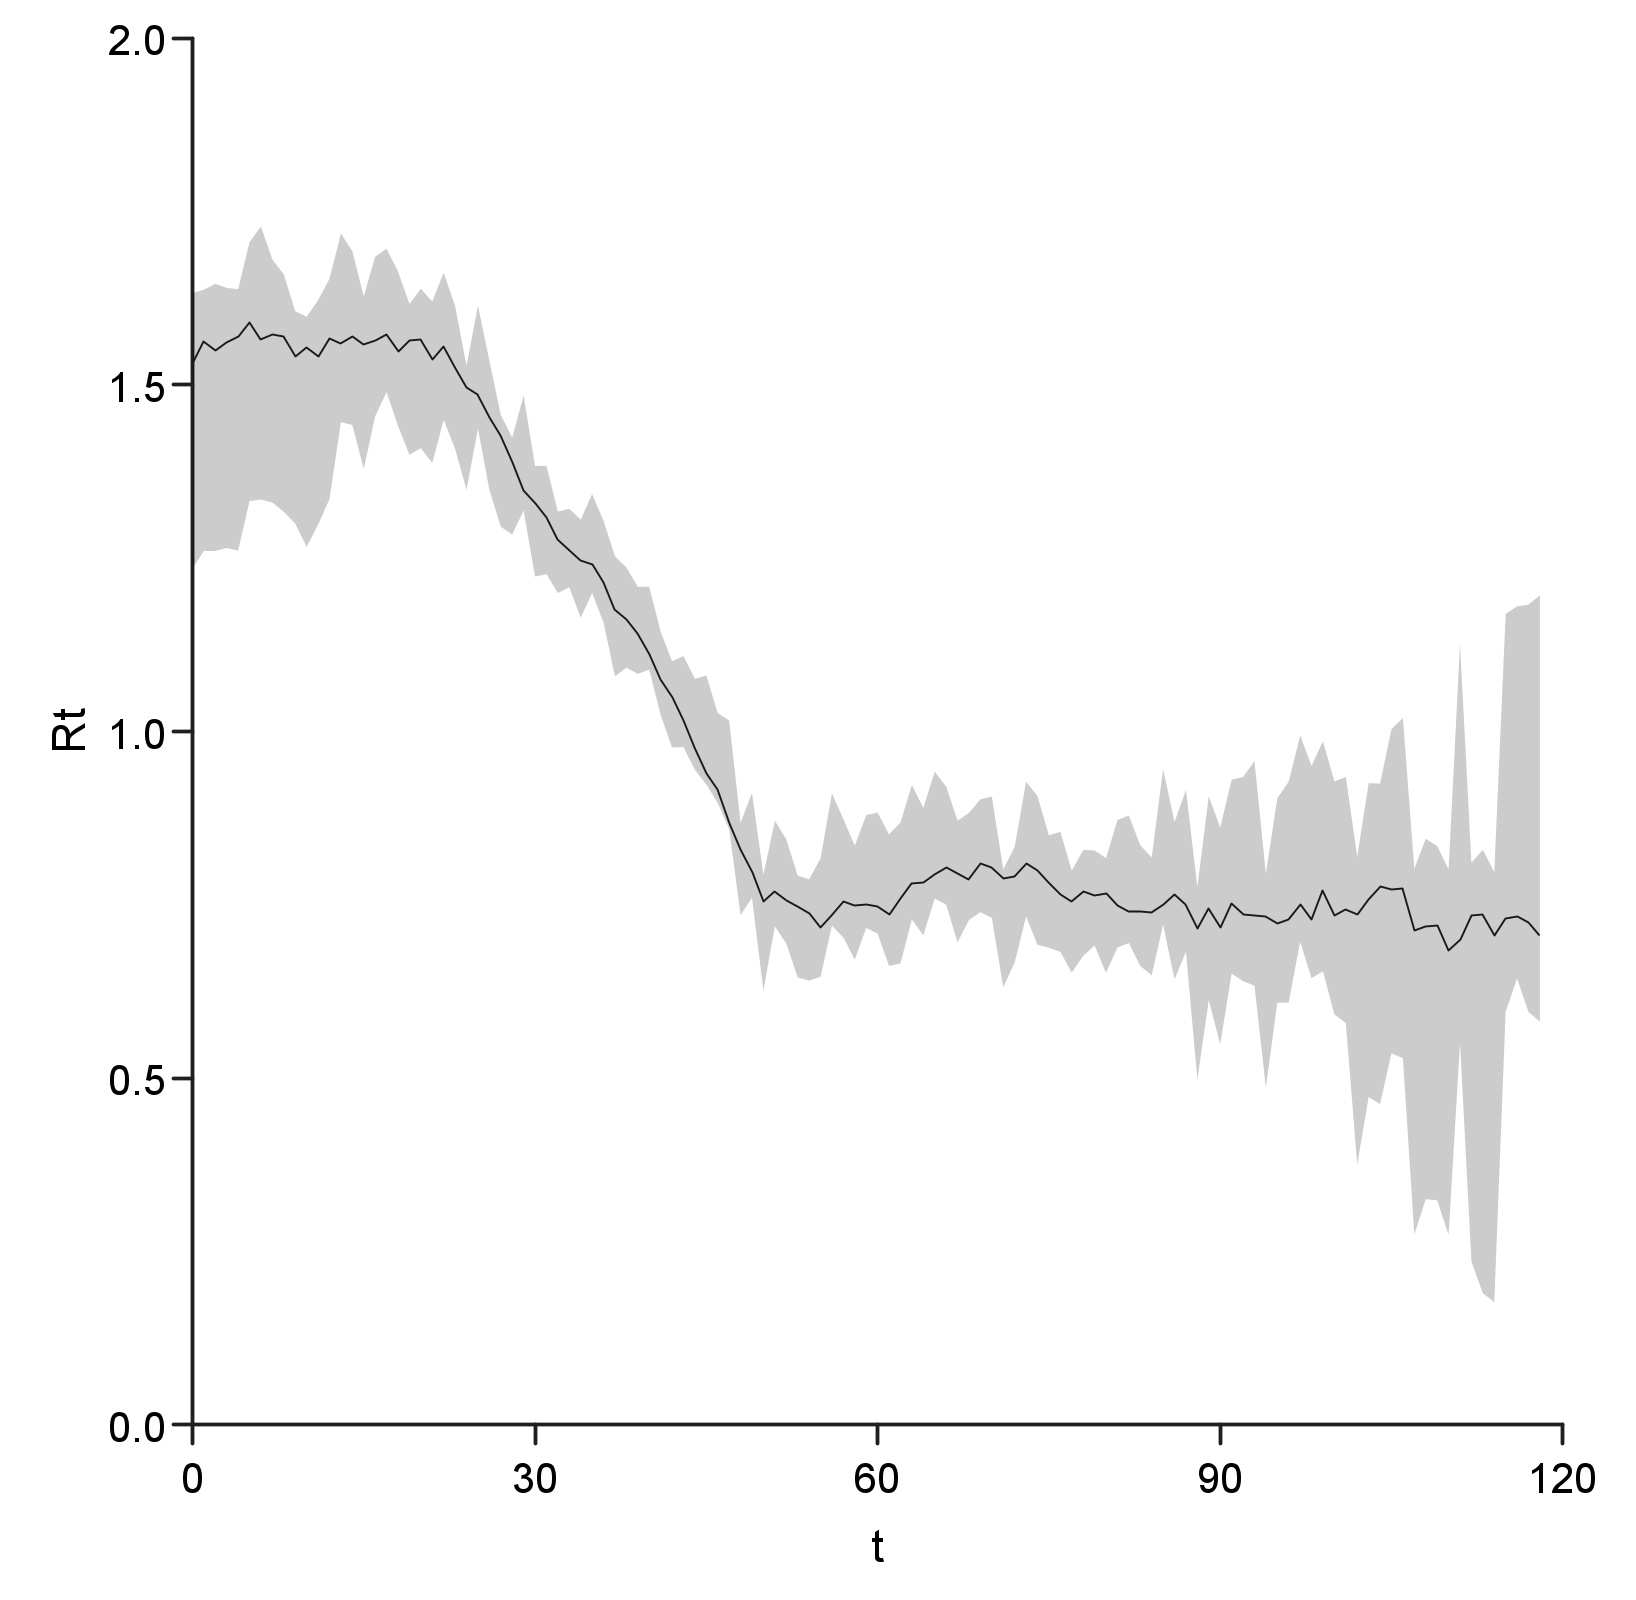

In [37]:
{{
    val RtsDistributionStats(means, medians, hdpis_90, hdpis_50) = countryStats("Norway")
    show("t", "Rt", line(medians), shade(hdpis_50))
}}

## Saving the results

In [39]:
def datesForCountry(country: String) = {
    countriesOnsetData.collect {
        case m if m("country") == country => m("date")
    }
}

defined function datesForCountry

In [40]:
def writeStatsToCsv(country: String, stats: RtsDistributionStats, csvWriter: CSVWriter): Unit = {
    val means_medians = stats.means.unzip._2 zip stats.medians.unzip._2
    val hdpis = stats.hdpis_90.unzip._2 zip stats.hdpis_50.unzip._2
    val xs = means_medians zip hdpis
    val dates = datesForCountry(country)
//     assert(xs.size == dates.size, s"${xs.size} != ${dates.size}")
    (xs zip dates) foreach {
        case (((mean, median),((low90,high90),(low50,high50))), date) => 
            csvWriter.writeRow(country :: date :: mean.toString :: median.toString :: low90.toString :: high90.toString 
                               :: low50.toString :: high50.toString :: Nil)
    }
}

defined function writeStatsToCsv

In [41]:
val csvWriter = CSVWriter.open(new File("data/rt-rainier.csv"))

csvWriter: CSVWriter = com.github.tototoshi.csv.CSVWriter@61839597

In [42]:
csvWriter.writeRow(List("region", "date", "mean", "median", "lower_90", "upper_90", "lower_50", "upper_50"))

In [43]:
countryStats.toList.sortBy(_._1).foreach {
    case (country, stats) => writeStatsToCsv(country, stats, csvWriter)
}

In [44]:
csvWriter.close()

## Processing logs

In [45]:
val csvData = {
    val csvReader = CSVReader.open(new File("data/rhats.csv"))
    val data = csvReader.allWithHeaders()
    csvReader.close()
    data
}

csvData: List[Map[String, String]] = List()

In [46]:
def writeCountryLogs(writer: CSVWriter, country: String) = {
    val countryData = csvData filter (_("country") == country)
    val countryMaxIdx = if (countryData.isEmpty) 0 else (countryData collect { case m => m("idx").toInt}).max + 1
    val additionalData = countryLogs(country).zipWithIndex.map {
        case (value,i) => Map("country" -> country, "idx" -> countryMaxIdx.toString, 
                              "iteration" -> i.toString, "rhat" -> value.toString)
    }
    val allData = countryData ++ additionalData
    for(elem <- allData) {
        writer.writeRow(country :: elem("idx") :: elem("iteration") :: elem("rhat") :: Nil)
    }
}

val countriesInCsv = (csvData collect { case m => m("country")}).toSet
val countriesInLogs = countryLogs.keys.toSet
val allCountries = (countriesInCsv ++ countriesInLogs).toList.sorted
val csvLogsWriter = CSVWriter.open(new File("data/rhats.csv"))
csvLogsWriter.writeRow(List("country", "idx", "iteration", "rhat"))
allCountries.foreach(writeCountryLogs(csvLogsWriter, _))
csvLogsWriter.close()

defined function writeCountryLogs
countriesInCsv: Set[String] = Set()
countriesInLogs: Set[String] = Set(
  "Poland",
  "Croatia",
  "Luxembourg",
  "Greece",
  "Spain",
  "Russia",
  "Estonia",
  "Czechia",
  "Romania",
  "Denmark",
  "Belgium",
  "Slovenia",
  "Malta",
  "Belarus",
  "Slovakia",
  "Finland",
  "Lithuania",
  "Sweden",
  "United_Kingdom",
  "Austria",
  "Latvia",
  "Italy",
  "Ireland",
  "Bulgaria",
  "Norway",
  "Netherlands",
  "Switzerland",
  "Cyprus",
  "Germany",
  "Portugal",
  "Hungary"
)
allCountries: List[String] = List(
  "Austria",
  "Belarus",
  "Belgium",
  "Bulgaria",
  "Croatia",
  "Cyprus",
  "Czechia",
  "Denmark",
  "Estonia",
  "Finland",
  "Germany",
  "Greece",
  "Hungary",
  "Ireland",
  "Italy",
  "Latvia",
  "Lithuania",
  "Luxembourg",
  "Malta",
  "Netherlands",
  "Norway",
  "Poland",
  "Portugal",
  "Romania",
  "Russia",
  "Slovakia",
  "Slovenia",
  "Spain",
  "Sweden",
  "Switzerland",
  "United_Kingdom"
)
csvLogsWriter: CSVWriter = co